In [1]:
import numpy as np
import pandas as pd
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import font_manager, rc
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# kepsh2 데이터 로딩
- 210703~ 220729 데이터

In [2]:
df = pd.read_csv('./data/220729/220729 kepsh2.csv', parse_dates = True, encoding = 'unicode_escape')

In [3]:
df['DateTime']= pd.to_datetime(df['DateTime'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528998 entries, 0 to 528997
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   DateTime              528998 non-null  datetime64[ns]
 1   Heatpump_Load(W)      528370 non-null  float64       
 2   Plug(W)               528370 non-null  float64       
 3   FCU_Load(W)           528370 non-null  float64       
 4   BIPV_Supply(W)        528370 non-null  float64       
 5   Pvt_Supply(W)         528370 non-null  float64       
 6   Room_Temp(°C)         528370 non-null  float64       
 7   RoomCon_Set_Temp(°C)  528370 non-null  float64       
 8   RoomCon_Mode          528370 non-null  float64       
 9   CS1(°C)               528370 non-null  float64       
 10  CS2(°C)               528370 non-null  float64       
 11  CS3(°C)               528370 non-null  float64       
 12  CS4(°C)               528370 non-null  float64       
 13 

In [5]:
df = df.set_index('DateTime')

In [9]:
# CS1온도가 58oC 이상 넘으면 (-1)곱하고, 100으로 나눠줄것 (음수값 이상하게 받아옴)
df.loc[df['CS1(°C)'] > 58, 'CS1(°C)'] = df['CS1(°C)']*(-1/100)

In [10]:
# 이상치 제거 (Room Temp가 5oC 이하인경우: 데이터 끊긴것으로 간주)
df= df[df['Room_Temp(°C)']>=10]
df= df[df['CS14(°C)']<=60]
df= df[df['CS9(°C)']<=60]
df= df[df['F3(lpm)']<=30]

In [11]:
# HP 부하 정리 
df.loc[df['F2(lpm)'] > 1, 'Heatpump_Load(W)'] = df['Heatpump_Load(W)'] - 6

In [12]:
# HP열량계산
df.loc[(df['F3(lpm)'] > 0.5) & (df['RoomCon_Mode'] == 0), 'Qgen_heat(W)'] = (df['CS10(°C)'] - df['CS9(°C)']) * 4.19 * df['F3(lpm)'] * 1000/60
df.loc[(df['F3(lpm)'] > 0.5) & (df['RoomCon_Mode'] == 1), 'Qgen_cool(W)'] = (df['CS9(°C)'] - df['CS10(°C)']) * 4.19 * df['F3(lpm)'] * 1000/60
df.loc[(df['F2(lpm)'] > 0.5) & (df['RoomCon_Mode'] == 0), 'Qsupply_heat(W)'] = (df['CS13(°C)'] - df['CS14(°C)']) * 4.19 * df['F2(lpm)'] * 1000/60
df.loc[(df['F5(lpm)'] > 0.5) & (df['RoomCon_Mode'] == 1), 'Qsupply_cool(W)'] = (df['CS13(°C)'] - df['CS16(°C)']) * 4.19 * df['F5(lpm)'] * 1000/60

In [13]:
#PVT생산열 계산 
df.loc[(df['F1(lpm)'] > 1.0) & (df['CS17(°C)'] > 10) &(df['CS1(°C)'] >= df['CS17(°C)']) & ((df['Valve6(MV6)'] == 0) | (df['Valve1(MV1)'] == 1)), 'Qpvt(W)'] = (df['CS1(°C)'] - df['CS17(°C)']) * 4.19 * df['F1(lpm)'] * 1000/60
# df.loc[(df['F1(lpm)'] > 0.5) & (df['CS17(°C)'] > 10) & (df['CS1(°C)'] < 60) & (df['Valve6(MV6)'] == 0), 'Qpvt(W)'] = (df['CS1(°C)'] - df['CS17(°C)']) * 4.19 * df['F1(lpm)'] * 1000/60

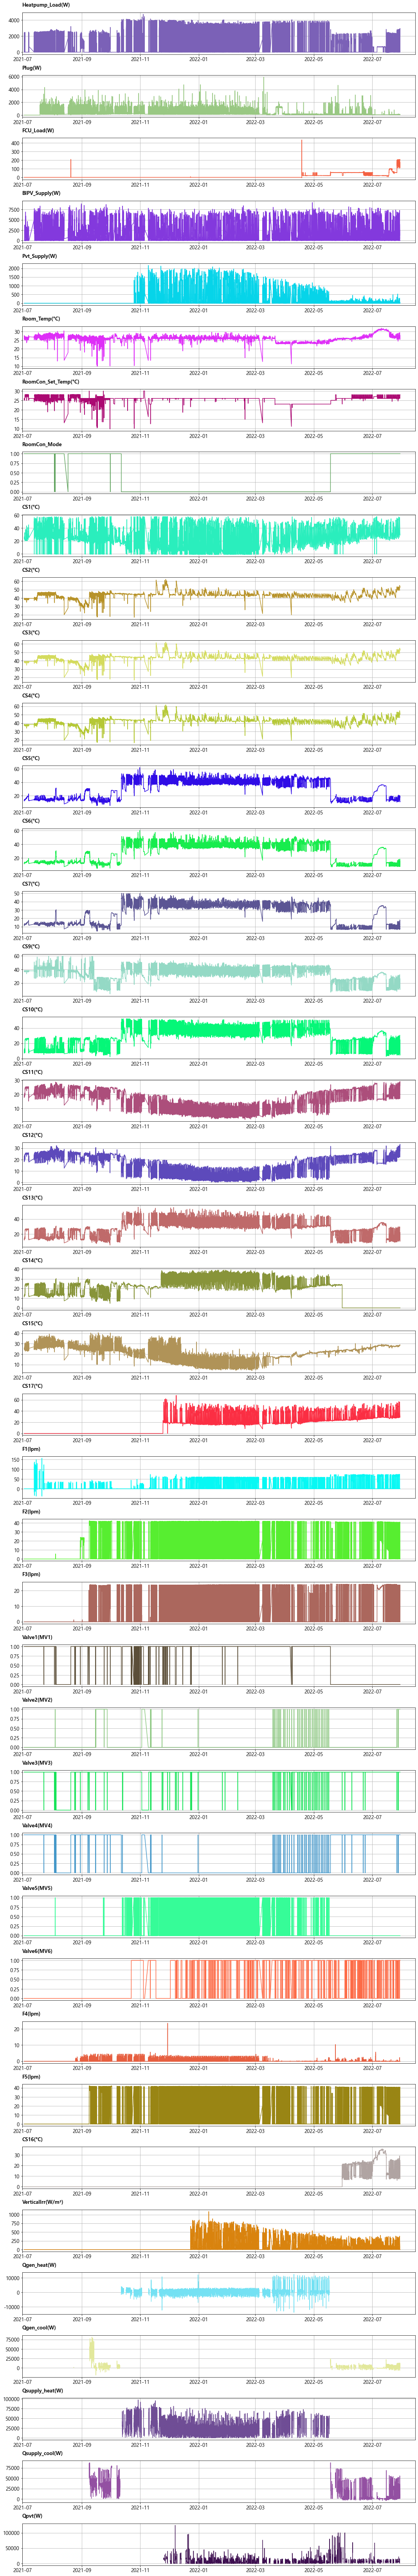

In [14]:
fig, ax = plt.subplots(figsize=(18,120))

for i in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df.index, df[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-07-01'), pd.Timestamp('2022-08-15'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

In [26]:
df_kepsh2 = df[['BIPV_Supply(W)', 'Pvt_Supply(W)', 'Qpvt(W)', 'Heatpump_Load(W)', 'Qgen_heat(W)', 'Qsupply_heat(W)', 'Qgen_cool(W)','Qsupply_cool(W)']]

In [27]:
df_kepsh2

,BIPV_Supply(W),Pvt_Supply(W),Qpvt(W),Heatpump_Load(W),Qgen_heat(W),Qsupply_heat(W),Qgen_cool(W),Qsupply_cool(W)
DateTime,,,,,,,,
2022-07-30 01:13:00,-32.0,-2.0,NaN,6.0,NaN,NaN,NaN,NaN
2022-07-30 01:12:00,-32.0,-2.0,NaN,6.0,NaN,NaN,NaN,NaN
2022-07-30 01:11:00,-32.0,-2.0,NaN,6.0,NaN,NaN,NaN,NaN
2022-07-30 01:10:00,-32.0,-2.0,NaN,6.0,NaN,NaN,NaN,NaN
2022-07-30 01:09:00,-32.0,-2.0,NaN,6.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-03 00:04:00,-32.0,1.0,NaN,258.0,NaN,NaN,NaN,NaN
2021-07-03 00:03:00,-32.0,1.0,NaN,6.0,NaN,NaN,NaN,NaN
2021-07-03 00:02:00,-32.0,1.0,NaN,6.0,NaN,NaN,NaN,NaN


## PVT분석

In [15]:
df_pvt = df[['VerticalIrr(W/m²)','F1(lpm)','CS1(°C)','CS17(°C)','Valve6(MV6)', 'Valve1(MV1)',  'Qpvt(W)'  ]]

In [16]:
# # CS1온도가 60oC 이상 넘으면 (-1)곱하고, 100으로 나눠줄것 (음수값 이상하게 받아옴)
# df_pvt.loc[df_pvt['CS1(°C)'] > 65, 'CS1(°C)'] = df_pvt['CS1(°C)']*(-1/100)

In [17]:
df_pvt

,VerticalIrr(W/m²),F1(lpm),CS1(°C),CS17(°C),Valve6(MV6),Valve1(MV1),Qpvt(W)
DateTime,,,,,,,
2022-07-30 01:13:00,0.0,0.186,28.9180,28.922,1.0,0.0,NaN
2022-07-30 01:12:00,0.0,0.183,28.9230,28.925,1.0,0.0,NaN
2022-07-30 01:11:00,0.0,0.185,28.9150,28.932,1.0,0.0,NaN
2022-07-30 01:10:00,0.0,0.184,28.9450,28.938,1.0,0.0,NaN
2022-07-30 01:09:00,0.0,0.182,28.9630,28.935,1.0,0.0,NaN
...,...,...,...,...,...,...,...
2021-07-03 00:04:00,0.0,0.000,26.2250,0.000,0.0,1.0,NaN
2021-07-03 00:03:00,0.0,0.000,26.2400,0.000,0.0,1.0,NaN
2021-07-03 00:02:00,0.0,0.000,25.8102,0.000,0.0,1.0,NaN


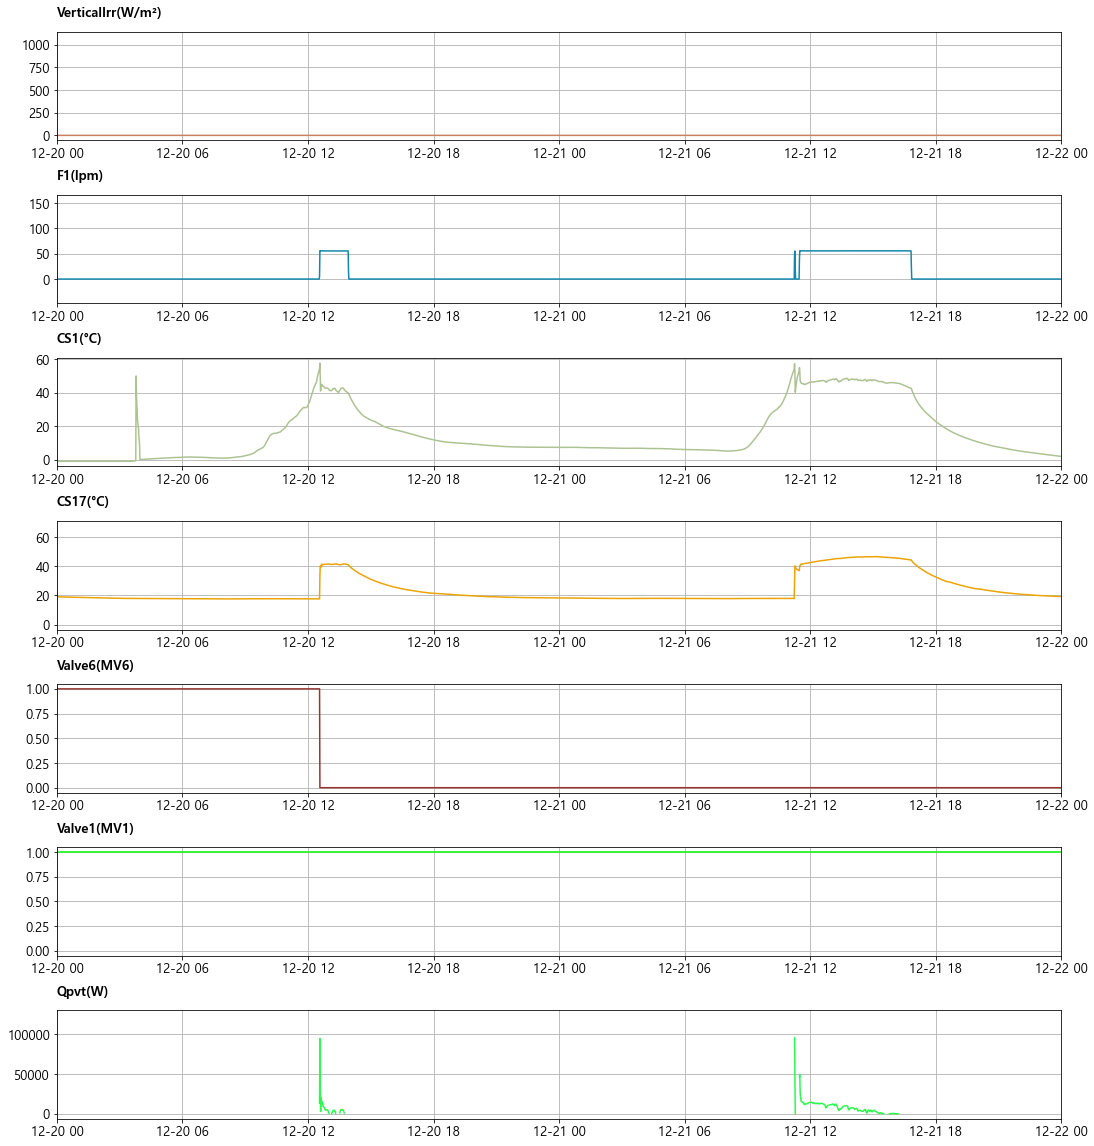

In [22]:
fig, ax = plt.subplots(figsize=(18,20))

for i in range(len(df_pvt.columns)):
    plt.subplot(len(df_pvt.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_pvt.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_pvt.index, df_pvt[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-12-20'), pd.Timestamp('2021-12-22'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

# 1시간 단위 분석

In [28]:
df_kepsh2_1h = df_kepsh2.resample('1h').sum()/60/1000

In [29]:
df_kepsh2_1h = df_kepsh2_1h.rename(columns={'Heatpump_Load(W)':'Heatpump_Load(kWh)',
                                        'Qgen_heat(W)':'Qgen_heat(kWh)',
                                        'Qgen_cool(W)':'Qgen_cool(kWh)',
                                        'Qsupply_heat(W)':'Qsupply_heat(kWh)',
                                        'Qsupply_cool(W)':'Qsupply_cool(kWh)',
                                        'BIPV_Supply(W)':'BIPV_Supply(kWh)',
                                        'Pvt_Supply(W)':'Pvt_Supply(kWh)',
                                        'Qpvt(W)':'Qpvt(kWh)'})

In [30]:
df_kepsh2_1h['Heating_COP'] = df_kepsh2_1h['Qgen_heat(kWh)'] / df_kepsh2_1h['Heatpump_Load(kWh)']
df_kepsh2_1h['Heating_COP_2'] = df_kepsh2_1h['Qsupply_heat(kWh)'] / df_kepsh2_1h['Heatpump_Load(kWh)']
df_kepsh2_1h['Cooling_COP'] = df_kepsh2_1h['Qgen_cool(kWh)'] / df_kepsh2_1h['Heatpump_Load(kWh)']
df_kepsh2_1h['Cooling_COP_2'] = df_kepsh2_1h['Qsupply_cool(kWh)'] / df_kepsh2_1h['Heatpump_Load(kWh)']


In [31]:
df_kepsh2_1h = df_kepsh2_1h[df_kepsh2_1h['Heating_COP']<5]
df_kepsh2_1h = df_kepsh2_1h[df_kepsh2_1h['Cooling_COP']<5]
df_kepsh2_1h = df_kepsh2_1h[df_kepsh2_1h['Heating_COP']>=0]
df_kepsh2_1h = df_kepsh2_1h[df_kepsh2_1h['Cooling_COP']>=0]
# df_ashp_1h = df_ashp_1h[df_ashp_1h['Pvt_Supply(kWh)']>-0.1]

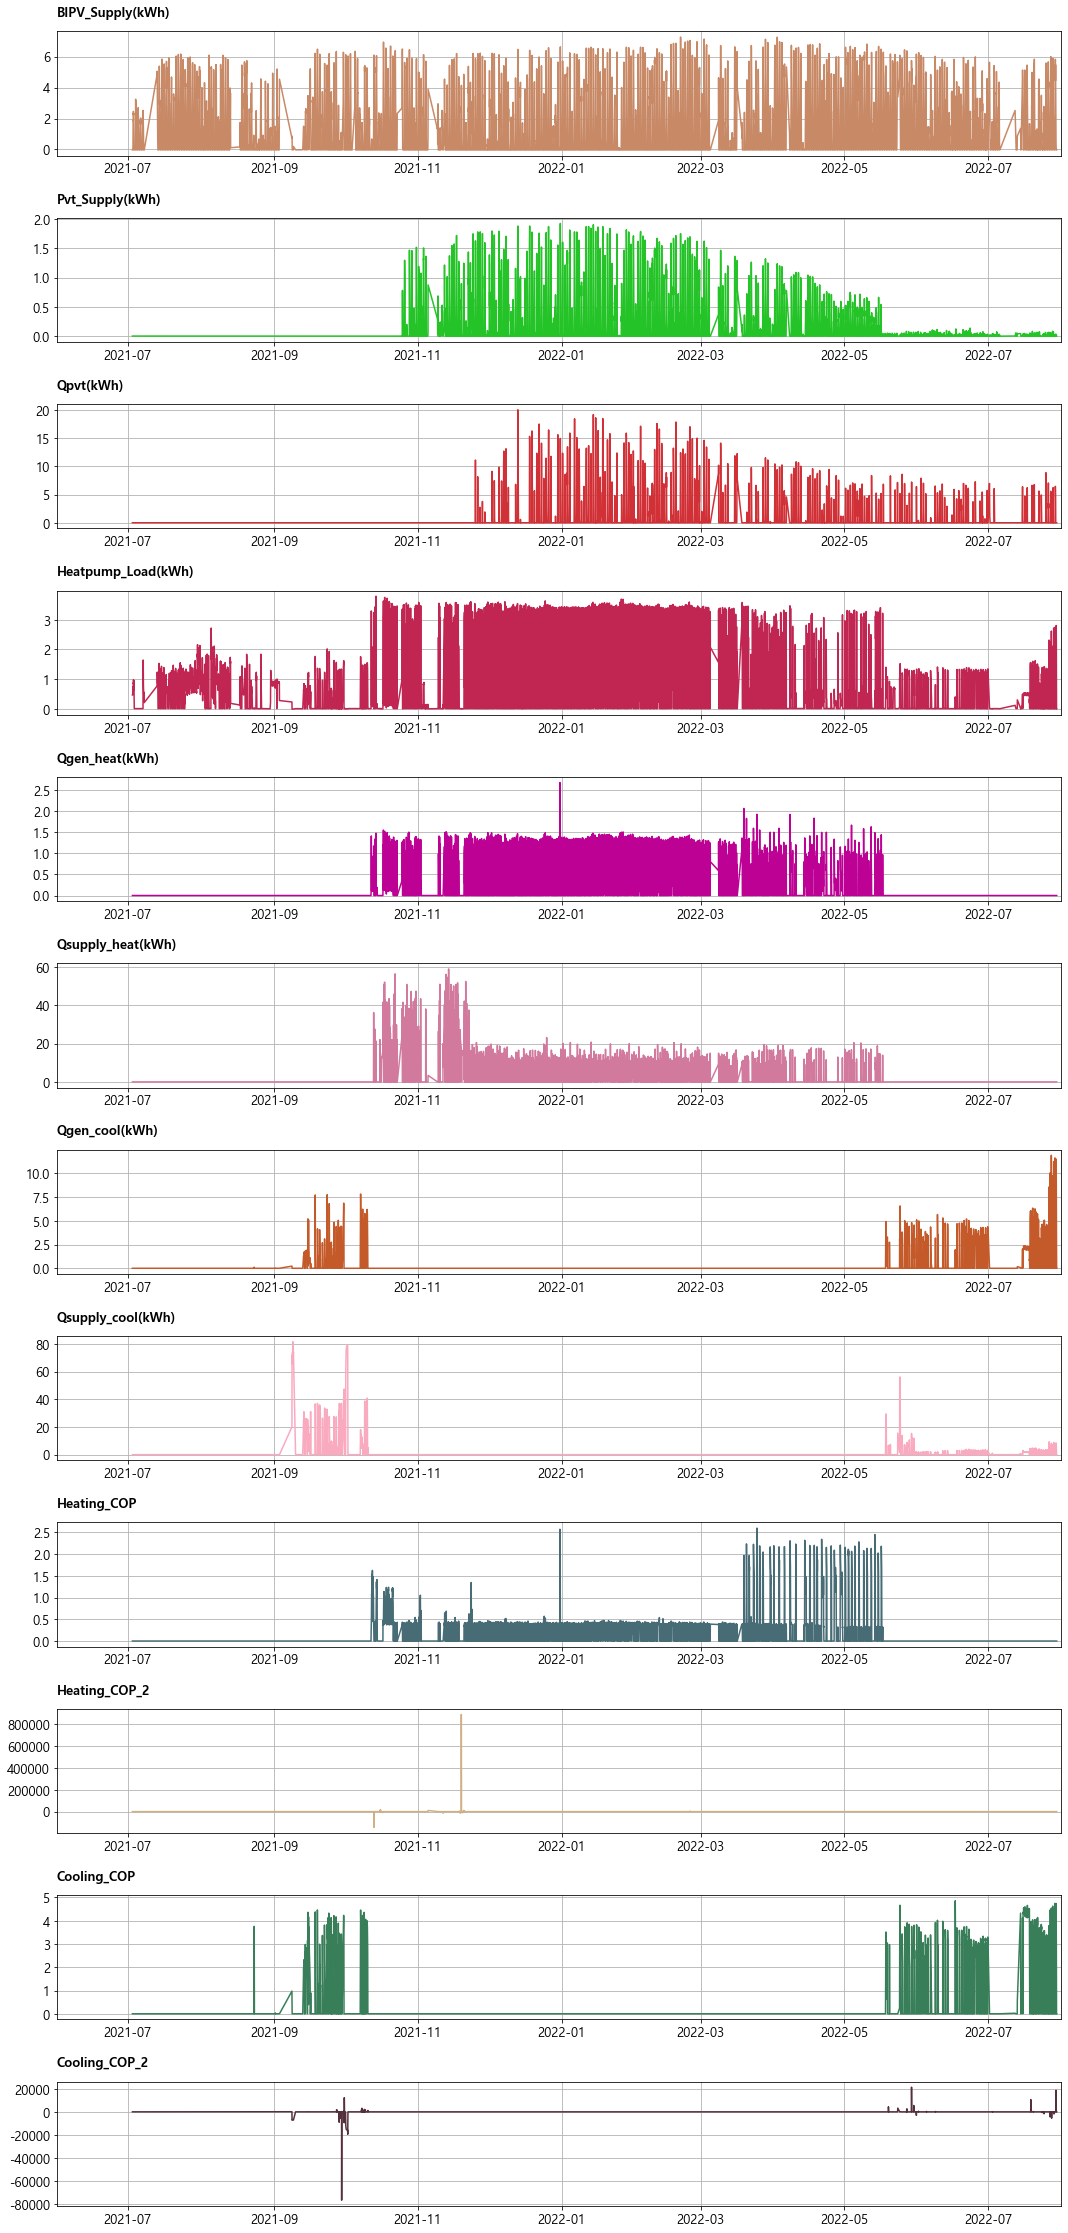

In [32]:
fig, ax = plt.subplots(figsize=(18,40))

for i in range(len(df_kepsh2_1h.columns)):
    plt.subplot(len(df_kepsh2_1h.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_kepsh2_1h.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kepsh2_1h.index, df_kepsh2_1h[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-06-01'), pd.Timestamp('2022-08-01'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

# 1일단위 분석 

In [33]:
df_kepsh2_1d = df_kepsh2.resample('1d').sum()/60/1000

In [34]:
df_kepsh2_1d = df_kepsh2_1d.rename(columns={'Heatpump_Load(W)':'Heatpump_Load(kWh)',
                                        'Qgen_heat(W)':'Qgen_heat(kWh)',
                                        'Qgen_cool(W)':'Qgen_cool(kWh)',
                                        'Qsupply_heat(W)':'Qsupply_heat(kWh)',
                                        'Qsupply_cool(W)':'Qsupply_cool(kWh)',
                                        'BIPV_Supply(W)':'BIPV_Supply(kWh)',
                                        'Pvt_Supply(W)':'Pvt_Supply(kWh)',
                                        'Qpvt(W)':'Qpvt(kWh)'})

In [35]:
df_kepsh2_1d['Heating_COP'] = df_kepsh2_1d['Qgen_heat(kWh)'] / df_kepsh2_1d['Heatpump_Load(kWh)']
df_kepsh2_1d['Heating_COP_2'] = df_kepsh2_1d['Qsupply_heat(kWh)'] / df_kepsh2_1d['Heatpump_Load(kWh)']
df_kepsh2_1d['Cooling_COP'] = df_kepsh2_1d['Qgen_cool(kWh)'] / df_kepsh2_1d['Heatpump_Load(kWh)']
df_kepsh2_1d['Cooling_COP_2'] = df_kepsh2_1d['Qsupply_cool(kWh)'] / df_kepsh2_1d['Heatpump_Load(kWh)']


In [36]:
df_kepsh2_1d = df_kepsh2_1d[df_kepsh2_1d['Heating_COP_2']<5]
df_kepsh2_1d = df_kepsh2_1d[df_kepsh2_1d['Cooling_COP']<5]
# df_kepsh2_1d = df_kepsh2_1d[df_kepsh2_1d['Heating_COP_2']>=0]
# df_kepsh2_1d = df_kepsh2_1d[df_kepsh2_1d['Cooling_COP']>=0]
# df_ashp_1d = df_ashp_1d[df_ashp_1d['Pvt_Supply(kWh)']>-0.1]

In [37]:
df_kepsh2_1d.describe()

,BIPV_Supply(kWh),Pvt_Supply(kWh),Qpvt(kWh),Heatpump_Load(kWh),Qgen_heat(kWh),Qsupply_heat(kWh),Qgen_cool(kWh),Qsupply_cool(kWh),Heating_COP,Heating_COP_2,Cooling_COP,Cooling_COP_2
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,30.460149,3.130087,17.588524,16.401267,5.065551,38.558474,5.713090,23.723458,0.246997,1.592521,0.631604,286.082252
std,13.910532,3.767332,22.225271,12.337884,5.942325,48.032016,14.439803,88.503725,0.299405,1.640477,1.356561,4417.125311
min,-0.162667,-0.007300,0.000000,0.007400,0.000000,0.000000,-18.280908,0.000000,0.000000,0.000000,-1.315052,0.000000
25%,19.571483,0.023417,0.000000,6.900333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34.014283,0.467767,8.431536,13.061850,1.486357,0.000000,0.000000,0.000000,0.300516,0.000000,0.000000,0.000000
75%,41.589717,6.102833,26.295976,24.209900,9.626023,77.782268,0.000000,3.072042,0.395546,3.211312,0.000000,0.428883
max,52.671667,11.438733,82.372282,49.840750,20.326849,157.030563,69.642684,937.345681,1.804137,4.716360,4.779105,79774.100506


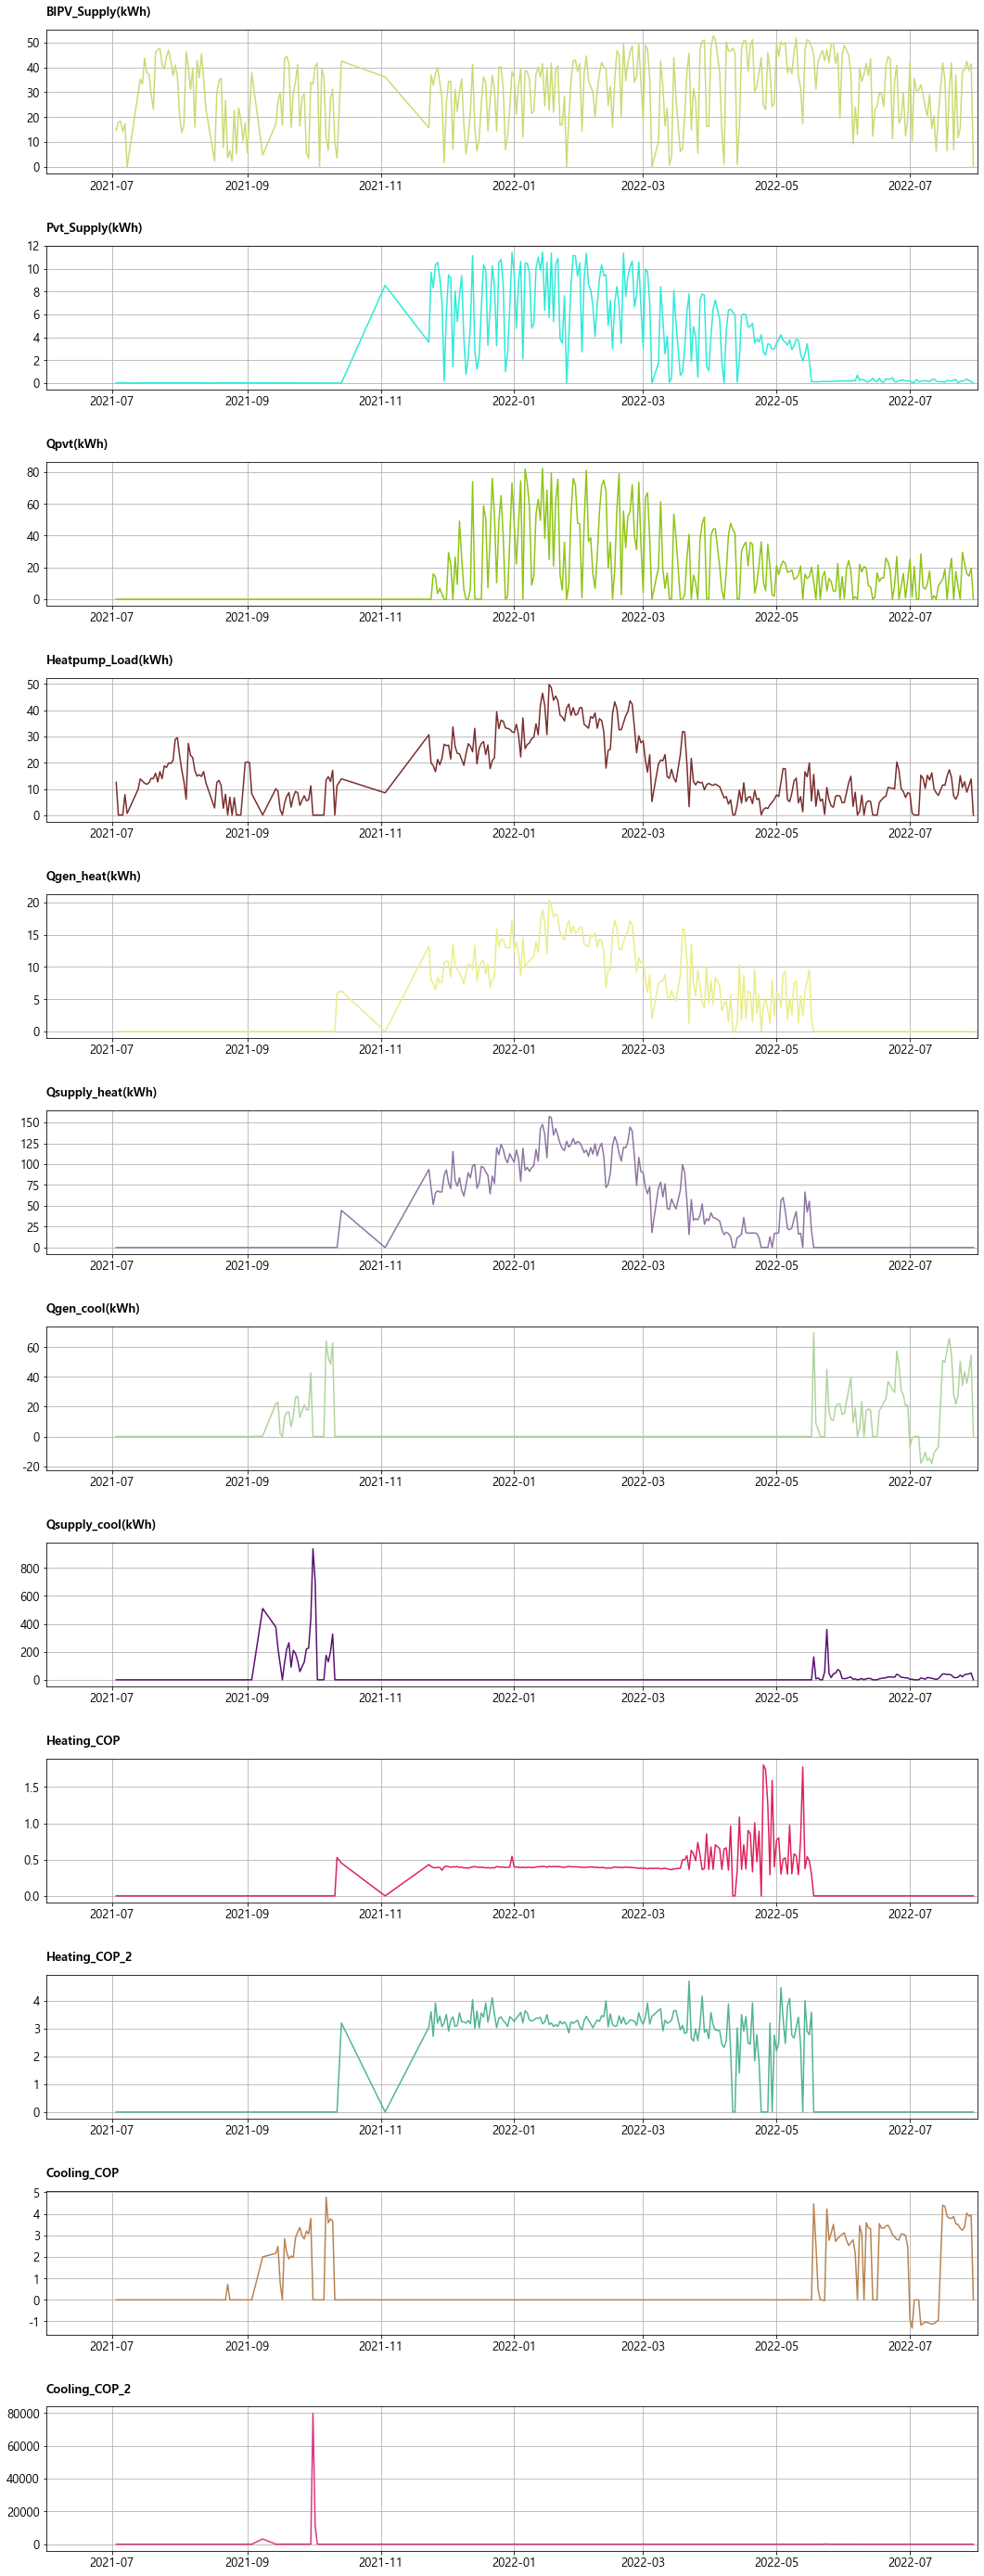

In [52]:
fig, ax = plt.subplots(figsize=(18,50))

for i in range(len(df_kepsh2_1d.columns)):
    plt.subplot(len(df_kepsh2_1d.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_kepsh2_1d.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kepsh2_1d.index, df_kepsh2_1d[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-06-01'), pd.Timestamp('2022-08-01'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

In [39]:
df_kepsh2_1d.loc['2022-07']

,BIPV_Supply(kWh),Pvt_Supply(kWh),Qpvt(kWh),Heatpump_Load(kWh),Qgen_heat(kWh),Qsupply_heat(kWh),Qgen_cool(kWh),Qsupply_cool(kWh),Heating_COP,Heating_COP_2,Cooling_COP,Cooling_COP_2
DateTime,,,,,,,,,,,,
2022-07-01,42.196583,0.193667,25.068735,8.222700,0.0,0.0,-7.343370,3.935477,0.0,0.0,-0.893061,0.478611
2022-07-02,10.400217,0.051583,1.470248,0.816817,0.0,0.0,-1.074156,4.291035,0.0,0.0,-1.315052,5.253364
2022-07-03,35.625050,0.061833,20.494579,0.141617,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2022-07-04,30.587517,0.316650,0.000000,0.141467,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2022-07-05,30.796867,0.105317,0.000000,0.136317,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2022-07-06,32.981200,0.137400,28.596391,15.287050,0.0,0.0,-17.933953,12.647483,0.0,0.0,-1.173147,0.827333
2022-07-07,29.402533,0.211517,7.700952,14.076650,0.0,0.0,-15.516980,9.385851,0.0,0.0,-1.102320,0.666767
2022-07-08,23.770433,0.180717,6.332901,10.273617,0.0,0.0,-10.602243,4.406177,0.0,0.0,-1.031987,0.428883
2022-07-09,20.539467,0.186900,9.762654,15.249967,0.0,0.0,-16.101056,16.779515,0.0,0.0,-1.055809,1.100298


# 1주단위 분석

In [40]:
df_kepsh2_1W = df_kepsh2.resample('1W').sum()/60/1000

In [41]:
df_kepsh2_1W = df_kepsh2_1W.rename(columns={'Heatpump_Load(W)':'Heatpump_Load(kWh)',
                                        'Qgen_heat(W)':'Qgen_heat(kWh)',
                                        'Qgen_cool(W)':'Qgen_cool(kWh)',
                                        'Qsupply_heat(W)':'Qsupply_heat(kWh)',
                                        'Qsupply_cool(W)':'Qsupply_cool(kWh)',
                                        'BIPV_Supply(W)':'BIPV_Supply(kWh)',
                                        'Pvt_Supply(W)':'Pvt_Supply(kWh)',
                                        'Qpvt(W)':'Qpvt(kWh)'})

In [42]:
df_kepsh2_1W['Heating_COP'] = df_kepsh2_1W['Qgen_heat(kWh)'] / df_kepsh2_1W['Heatpump_Load(kWh)']
df_kepsh2_1W['Heating_COP_2'] = df_kepsh2_1W['Qsupply_heat(kWh)'] / df_kepsh2_1W['Heatpump_Load(kWh)']
df_kepsh2_1W['Cooling_COP'] = df_kepsh2_1W['Qgen_cool(kWh)'] / df_kepsh2_1W['Heatpump_Load(kWh)']
df_kepsh2_1W['Cooling_COP_2'] = df_kepsh2_1W['Qsupply_cool(kWh)'] / df_kepsh2_1W['Heatpump_Load(kWh)']


In [43]:
df_kepsh2_1W['2022-04' : ' 2022-05']

,BIPV_Supply(kWh),Pvt_Supply(kWh),Qpvt(kWh),Heatpump_Load(kWh),Qgen_heat(kWh),Qsupply_heat(kWh),Qgen_cool(kWh),Qsupply_cool(kWh),Heating_COP,Heating_COP_2,Cooling_COP,Cooling_COP_2
DateTime,,,,,,,,,,,,
2022-04-03,286.408333,35.864767,228.068462,81.052300,42.955475,259.808091,0.000000,0.000000,0.529972,3.205438,0.000000,0.000000
2022-04-10,247.332667,31.971117,176.249069,50.628067,28.980406,152.699951,0.000000,0.000000,0.572418,3.016113,0.000000,0.000000
2022-04-17,260.158150,32.163917,185.802906,36.246350,24.081719,95.783988,0.000000,0.000000,0.664390,2.642583,0.000000,0.000000
2022-04-24,283.460350,30.206567,162.945378,40.661400,31.930538,97.949823,0.000000,0.000000,0.785279,2.408914,0.000000,0.000000
2022-05-01,231.970483,21.354667,96.797917,30.703383,29.879372,47.252992,0.000000,0.000000,0.973162,1.539016,0.000000,0.000000
2022-05-08,309.778883,25.323650,135.918521,74.910717,37.207408,245.023501,0.000000,0.000000,0.496690,3.270874,0.000000,0.000000
2022-05-15,282.179783,21.293100,90.929528,71.744017,38.902385,220.534061,0.000000,0.000000,0.542239,3.073902,0.000000,0.000000
2022-05-22,309.243867,2.640483,80.547456,65.902017,11.236904,75.348890,83.111208,183.739776,0.170509,1.143347,1.261133,2.788075
2022-05-29,318.587633,1.033750,79.589607,38.454700,0.000000,0.000000,124.906620,641.459894,0.000000,0.000000,3.248150,16.680923


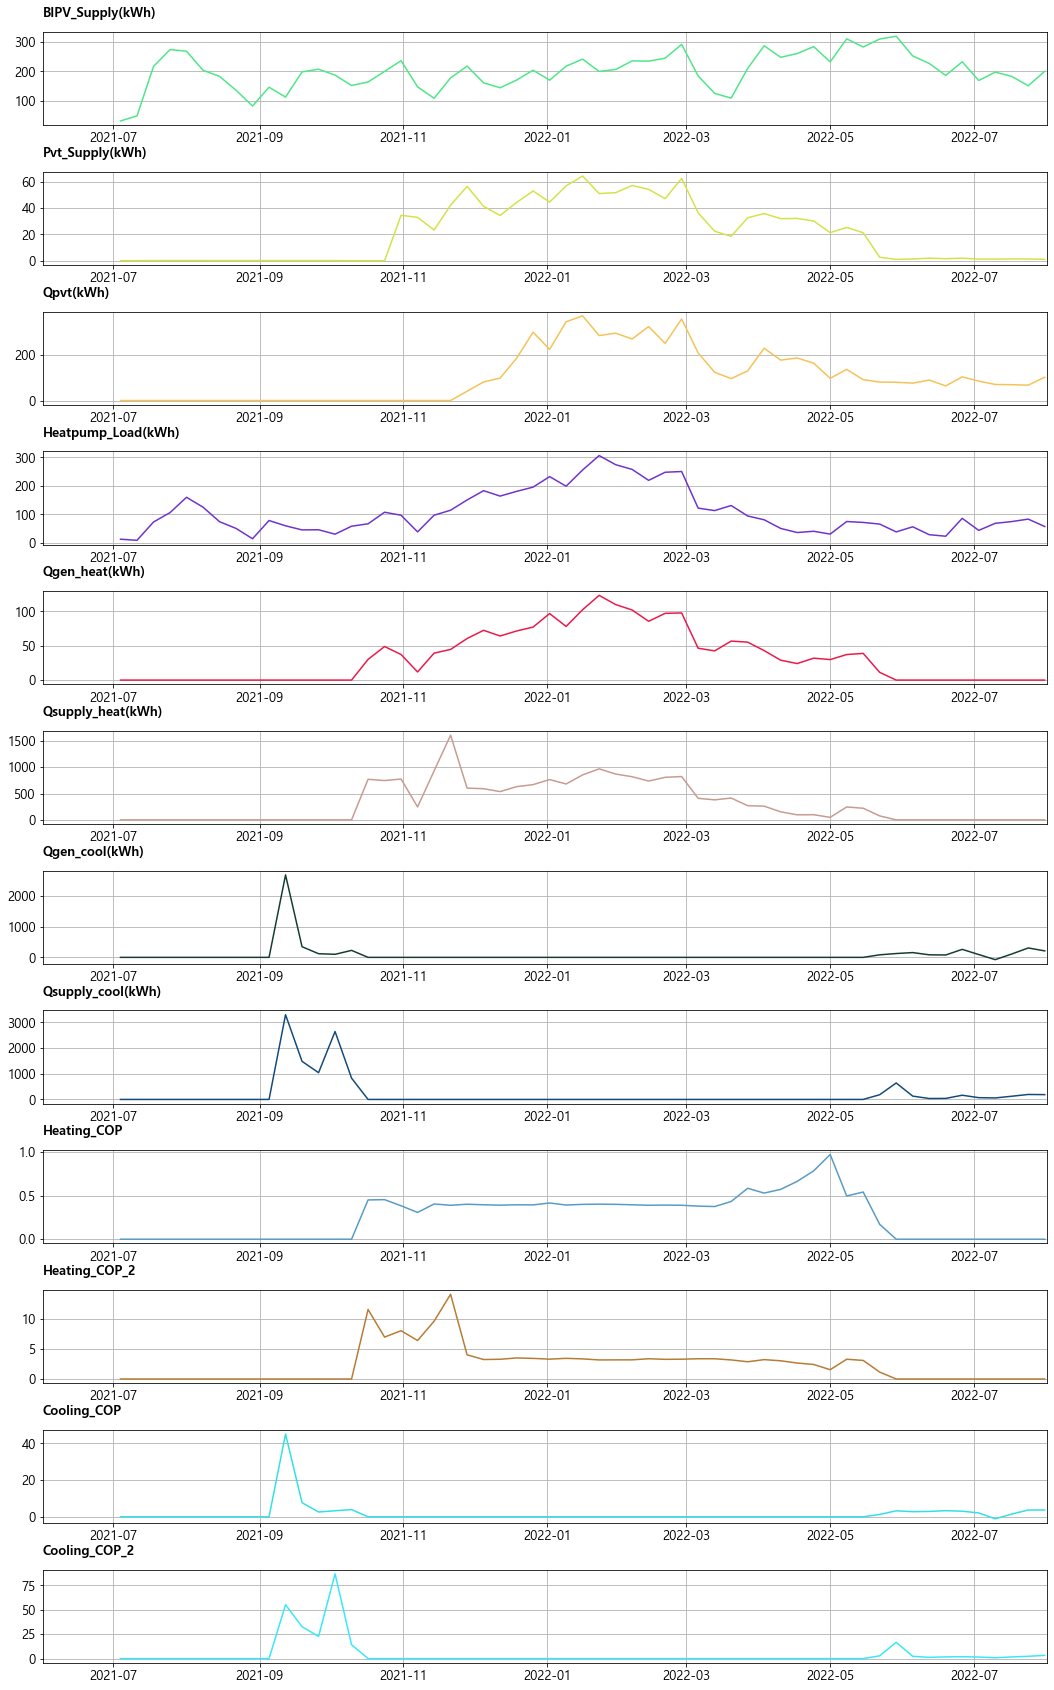

In [44]:
fig, ax = plt.subplots(figsize=(18,30))

for i in range(len(df_kepsh2_1W.columns)):
    plt.subplot(len(df_kepsh2_1W.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_kepsh2_1W.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kepsh2_1W.index, df_kepsh2_1W[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-06-01'), pd.Timestamp('2022-08-01'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

# 1달 단위 분석

In [45]:
df_kepsh2_1M = df_kepsh2.resample('1M').sum()/60/1000

In [46]:
df_kepsh2_1M = df_kepsh2_1M.rename(columns={'Heatpump_Load(W)':'Heatpump_Load(kWh)',
                                        'Qgen_heat(W)':'Qgen_heat(kWh)',
                                        'Qgen_cool(W)':'Qgen_cool(kWh)',
                                        'Qsupply_heat(W)':'Qsupply_heat(kWh)',
                                        'Qsupply_cool(W)':'Qsupply_cool(kWh)',
                                        'BIPV_Supply(W)':'BIPV_Supply(kWh)',
                                        'Pvt_Supply(W)':'Pvt_Supply(kWh)',
                                        'Qpvt(W)':'Qpvt(kWh)'})

In [47]:
df_kepsh2_1M['Heating_COP'] = df_kepsh2_1M['Qgen_heat(kWh)'] / df_kepsh2_1M['Heatpump_Load(kWh)']
df_kepsh2_1M['Heating_COP_2'] = df_kepsh2_1M['Qsupply_heat(kWh)'] / df_kepsh2_1M['Heatpump_Load(kWh)']
df_kepsh2_1M['Cooling_COP'] = df_kepsh2_1M['Qgen_cool(kWh)'] / df_kepsh2_1M['Heatpump_Load(kWh)']
df_kepsh2_1M['Cooling_COP_2'] = df_kepsh2_1M['Qsupply_cool(kWh)'] / df_kepsh2_1M['Heatpump_Load(kWh)']


In [48]:
df_kepsh2_1M

,BIPV_Supply(kWh),Pvt_Supply(kWh),Qpvt(kWh),Heatpump_Load(kWh),Qgen_heat(kWh),Qsupply_heat(kWh),Qgen_cool(kWh),Qsupply_cool(kWh),Heating_COP,Heating_COP_2,Cooling_COP,Cooling_COP_2
DateTime,,,,,,,,,,,,
2021-07-31,819.983567,0.540950,0.000000,338.422967,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-08-31,654.630350,0.588983,0.000000,317.344250,0.000000,0.000000,0.117561,0.000000,0.000000,0.000000,0.000370,0.000000
2021-09-30,708.814650,0.566633,0.000000,230.075617,0.000000,0.011550,3263.063167,6834.123580,0.000000,0.000050,14.182568,29.703815
2021-10-31,867.749933,34.567383,0.000000,330.136067,116.340193,2291.603159,228.229113,2468.890058,0.352401,6.941390,0.691318,7.478402
2021-11-30,681.346233,162.384050,43.738580,449.657633,174.820838,3537.769769,0.000000,0.000000,0.388787,7.867696,0.000000,0.000000
2021-12-31,764.846150,196.159133,810.858850,842.372183,337.762341,2818.400669,0.000000,0.000000,0.400966,3.345790,0.000000,0.000000
2022-01-31,963.554867,248.981133,1408.352948,1143.756900,456.785744,3716.892353,0.000000,0.000000,0.399373,3.249722,0.000000,0.000000
2022-02-28,998.002467,217.382100,1183.270166,963.258933,377.376728,3149.651354,0.000000,0.000000,0.391771,3.269787,0.000000,0.000000
2022-03-31,729.752133,121.438417,620.686192,479.505733,212.952713,1528.195925,0.000000,0.000000,0.444109,3.187023,0.000000,0.000000


In [49]:
df_kepsh2_1M[['BIPV_Supply(kWh)', 'Pvt_Supply(kWh)', 'Qpvt(kWh)' ]]

,BIPV_Supply(kWh),Pvt_Supply(kWh),Qpvt(kWh)
DateTime,,,
2021-07-31,819.983567,0.540950,0.000000
2021-08-31,654.630350,0.588983,0.000000
2021-09-30,708.814650,0.566633,0.000000
2021-10-31,867.749933,34.567383,0.000000
2021-11-30,681.346233,162.384050,43.738580
2021-12-31,764.846150,196.159133,810.858850
2022-01-31,963.554867,248.981133,1408.352948
2022-02-28,998.002467,217.382100,1183.270166
2022-03-31,729.752133,121.438417,620.686192


In [50]:
df_kepsh2_1M[['Heatpump_Load(kWh)','Qgen_heat(kWh)', 'Heating_COP', 'Qsupply_heat(kWh)', 'Heating_COP_2', 'Qgen_cool(kWh)', 'Cooling_COP', 'Qsupply_cool(kWh)'  ]]

,Heatpump_Load(kWh),Qgen_heat(kWh),Heating_COP,Qsupply_heat(kWh),Heating_COP_2,Qgen_cool(kWh),Cooling_COP,Qsupply_cool(kWh)
DateTime,,,,,,,,
2021-07-31,338.422967,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-08-31,317.344250,0.000000,0.000000,0.000000,0.000000,0.117561,0.000370,0.000000
2021-09-30,230.075617,0.000000,0.000000,0.011550,0.000050,3263.063167,14.182568,6834.123580
2021-10-31,330.136067,116.340193,0.352401,2291.603159,6.941390,228.229113,0.691318,2468.890058
2021-11-30,449.657633,174.820838,0.388787,3537.769769,7.867696,0.000000,0.000000,0.000000
2021-12-31,842.372183,337.762341,0.400966,2818.400669,3.345790,0.000000,0.000000,0.000000
2022-01-31,1143.756900,456.785744,0.399373,3716.892353,3.249722,0.000000,0.000000,0.000000
2022-02-28,963.258933,377.376728,0.391771,3149.651354,3.269787,0.000000,0.000000,0.000000
2022-03-31,479.505733,212.952713,0.444109,1528.195925,3.187023,0.000000,0.000000,0.000000


In [ ]:
df = df.set_index('DateTime')

In [ ]:
fig, ax = plt.subplots(figsize=(18,80))

for i in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-06-01'), pd.Timestamp('2022-08-01'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

In [ ]:
df['GSHP_inputE(We)'] = df['Grid2GSHP(We)'] + df['ESS2GSHP(We)']

In [ ]:
df_gshp = df[['DateTime', 'GSHP_inputE(We)', 'GSHP2CTES(Wt)', 'CTES2Cool(Wt)', 'GSHP2HTES(Wt)', 'HTES2Heat(Wt)']]

In [ ]:
df_gshp = df_gshp.set_index('DateTime')

In [ ]:
df_gshp_1d = df_gshp.resample('1d').sum()/60/1000

In [ ]:
df_gshp_1d = df_gshp_1d.rename(columns={'GSHP_inputE(We)':'GSHP_inputE(kWh)',
                                        'GSHP2CTES(Wt)':'GSHP2CTES(kWh)',
                                        'CTES2Cool(Wt)':'CTESCool(kWh)',
                                        'GSHP2HTES(Wt)':'GSHP2HTES(kWh)',
                                        'HTES2Heat(Wt)':'HTES2Heat(kWh)'})

In [ ]:
df_gshp_1d

In [ ]:
df_gshp_1d['Cooling_COP'] = df_gshp_1d['GSHP2CTES(kWh)'] / df_gshp_1d['GSHP_inputE(kWh)']
df_gshp_1d['Heating_COP'] = df_gshp_1d['GSHP2HTES(kWh)'] / df_gshp_1d['GSHP_inputE(kWh)']
df_gshp_1d['Heating_COP_load'] = df_gshp_1d['HTES2Heat(kWh)'] / df_gshp_1d['GSHP_inputE(kWh)'] # COP값이상해서 HTES2Heat로 대체

In [ ]:
df_gshp_1d.loc['2022-05-01':'2022-06-15']

In [ ]:
df_gshp_1d.loc['2021-11-01':'2021-11-30']

In [ ]:
df_gshp_1d.loc['2022-07-01':'2022-07-31']

# 1시간단위로 분석

In [ ]:
df_gshp_1h = df_gshp.resample('1h').sum()/60/1000

In [ ]:
df_gshp_1h = df_gshp_1h.rename(columns={'GSHP_inputE(We)':'GSHP_inputE(kWh)',
                                        'GSHP2CTES(Wt)':'GSHP2CTES(kWh)',
                                        'CTES2Cool(Wt)':'CTESCool(kWh)',
                                        'GSHP2HTES(Wt)':'GSHP2HTES(kWh)',
                                        'HTES2Heat(Wt)':'HTES2Heat(kWh)'})

In [ ]:
df_gshp_1h

In [ ]:
df_gshp_1h['Cooling_COP'] = df_gshp_1h['GSHP2CTES(kWh)'] / df_gshp_1h['GSHP_inputE(kWh)']
df_gshp_1h['Heating_COP'] = df_gshp_1h['GSHP2HTES(kWh)'] / df_gshp_1h['GSHP_inputE(kWh)']
df_gshp_1h['Heating_COP_load'] = df_gshp_1h['HTES2Heat(kWh)'] / df_gshp_1h['GSHP_inputE(kWh)']

In [ ]:
df_gshp_1h.loc['2022-07-27':'2022-07-28']

# 1달단위로 분석

In [ ]:
df_gshp_1M = df_gshp.resample('1M').sum()/60/1000

In [ ]:
df_gshp_1M = df_gshp_1M.rename(columns={'GSHP_inputE(We)':'GSHP_inputE(kWh)',
                                        'GSHP2CTES(Wt)':'GSHP2CTES(kWh)',
                                        'CTES2Cool(Wt)':'CTESCool(kWh)',
                                        'GSHP2HTES(Wt)':'GSHP2HTES(kWh)',
                                        'HTES2Heat(Wt)':'HTES2Heat(kWh)'})

In [ ]:
df_gshp_1M['Cooling_COP'] = df_gshp_1M['GSHP2CTES(kWh)'] / df_gshp_1M['GSHP_inputE(kWh)']
df_gshp_1M['Heating_COP'] = df_gshp_1M['GSHP2HTES(kWh)'] / df_gshp_1M['GSHP_inputE(kWh)']
df_gshp_1M['Heating_COP_load'] = df_gshp_1M['HTES2Heat(kWh)'] / df_gshp_1M['GSHP_inputE(kWh)']

In [ ]:
df_gshp_1M

In [ ]:
df3=df3.set_index('DateTime')

In [ ]:
df3

# KPEC 건물간 에너지흐름차트 로딩

In [ ]:
df4 = pd.read_csv('./data/220114/220114 building_information.csv', parse_dates = True)

In [ ]:
df4['DateTime']= pd.to_datetime(df4['DateTime'])

In [ ]:
df4=df4[(df4['DateTime']<'2022-01-01 00:00:00')]

In [ ]:
df4=df4.set_index('DateTime')

# KPEC 데이터 합치기

In [ ]:
df_kpec = pd.DataFrame()
df_kpec = pd.DataFrame(pd.date_range('2021-09-13 00:00:00', '2022-02-28 23:59:00', freq='T'), columns=['Time'])

In [ ]:
df_kpec

In [ ]:
df_kpec = df_kpec.set_index('Time')

In [ ]:
df_kpec['Cons_kpec(W)'] = df1['energyTotalConsume']
df_kpec['Prod_kpec(W)'] = df1['energyTotalProduce']
df_kpec['ESS_kpec(W)'] = df2['ESS1_Power(W)']*(-1)

In [ ]:
df_kpec

In [ ]:
df_kpec.info()

In [ ]:
df_kpec['PV_kpec(We)'] = df3['PVout(We)']
df_kpec['PVT_kpec(We)'] = df3['PVTout(We)']
df_kpec['FC_kpec(We)'] = df3['FCout(We)']
df_kpec['PlugLoad(We)'] = df3['PlugLoad(We)']
df_kpec['LightLoad(We)'] = df3['LightLoad(We)']
df_kpec['FromGrid(We)'] = df3['FromGrid(We)']
df_kpec['ToGrid(We)'] = df3['ToGrid(We)']
df_kpec['ToESS(We)'] = df3['ToESS(We)']
df_kpec['ESSout(We)'] = df3['ESSout(We)']
df_kpec['ESS2Grid(We)'] = df3['ESS2Grid(We)']
df_kpec['ESS2ASHP(We)'] = df3['ESS2ASHP(We)']
df_kpec['ESS2GSHP(We)'] = df3['ESS2GSHP(We)']
df_kpec['Grid2ASHP(We)'] = df3['Grid2ASHP(We)']
df_kpec['Grid2GSHP(We)'] = df3['Grid2GSHP(We)']
df_kpec['PVTHout(Wt)'] = df3['PVTHout(Wt)']
df_kpec['FCHout(Wt)'] = df3['FCHout(Wt)']
df_kpec['ASHP2HTES(Wt)'] = df3['ASHP2HTES(Wt)']
df_kpec['GSHP2CTES(Wt)'] = df3['GSHP2CTES(Wt)']
df_kpec['GSHP2HTES(Wt)'] = df3['GSHP2HTES(Wt)']
df_kpec['ASHP2Cool(Wt)'] = df3['ASHP2Cool(Wt)']
df_kpec['ASHP2Heat(Wt)'] = df3['ASHP2Heat(Wt)']
df_kpec['CTES2Cool(Wt)'] = df3['CTES2Cool(Wt)']
df_kpec['HTES2Heat(Wt)'] = df3['HTES2Heat(Wt)']
df_kpec['HTES2Water(Wt)'] = df3['HTES2Water(Wt)']
df_kpec['DirectElec(We)'] = df3['DirectElec(We)']
df_kpec['CoolLoad(Wt)'] = df3['CoolLoad(Wt)']
df_kpec['HeatLoad(Wt)'] = df3['HeatLoad(Wt)']
df_kpec['HotwaterLoad(Wt)'] = df3['HotwaterLoad(Wt)']

In [ ]:
df_kpec['PV_kpec(We)'] = np.where(df_kpec['PV_kpec(We)']<0, 0, df_kpec['PV_kpec(We)'])
df_kpec['PVT_kpec(We)'] = np.where(df_kpec['PVT_kpec(We)']<0, 0, df_kpec['PVT_kpec(We)'])
df_kpec['FC_kpec(We)'] = np.where(df_kpec['FC_kpec(We)']<0, 0, df_kpec['FC_kpec(We)'])
df_kpec['PlugLoad(We)'] = np.where(df_kpec['PlugLoad(We)']<0, 0, df_kpec['PlugLoad(We)'])

In [ ]:
df_kpec['Cons_acc_kpec(Wh)'] = df_kpec['Cons_kpec(W)'].cumsum()*60*1/3600
df_kpec['Prod_acc_kpec(Wh)'] = df_kpec['Prod_kpec(W)'].cumsum()*60*1/3600
df_kpec['ESS_acc_kpec(Wh)'] = df_kpec['ESS_kpec(W)'].cumsum()*60*1/3600

df_kpec['PV_acc_kpec(Wh)'] = df_kpec['PV_kpec(We)'].cumsum()*60*1/3600
df_kpec['PVT_acc_kpec(Wh)'] = df_kpec['PVT_kpec(We)'].cumsum()*60*1/3600
df_kpec['FC_acc_kpec(Wh)'] = df_kpec['FC_kpec(We)'].cumsum()*60*1/3600
df_kpec['PlugLoad_acc(Wh)'] = df_kpec['PlugLoad(We)'].cumsum()*60*1/3600
df_kpec['LightLoad_acc(Wh)'] = df_kpec['LightLoad(We)'].cumsum()*60*1/3600
df_kpec['FromGrid_acc(Wh)'] = df_kpec['FromGrid(We)'].cumsum()*60*1/3600
df_kpec['ToGrid_acc(Wh)'] = df_kpec['ToGrid(We)'].cumsum()*60*1/3600
df_kpec['ToESS_acc(Wh)'] = df_kpec['ToESS(We)'].cumsum()*60*1/3600
df_kpec['ESSout_acc(Wh)'] = df_kpec['ESSout(We)'].cumsum()*60*1/3600
df_kpec['ESS2Grid_acc(Wh)'] = df_kpec['ESS2Grid(We)'].cumsum()*60*1/3600
df_kpec['ESS2ASHP_acc(Wh)'] = df_kpec['ESS2ASHP(We)'].cumsum()*60*1/3600
df_kpec['ESS2GSHP_acc(Wh)'] = df_kpec['ESS2GSHP(We)'].cumsum()*60*1/3600
df_kpec['Grid2ASHP_acc(Wh)'] = df_kpec['Grid2ASHP(We)'].cumsum()*60*1/3600
df_kpec['Grid2GSHP_acc(Wh)'] = df_kpec['Grid2GSHP(We)'].cumsum()*60*1/3600
df_kpec['PVTHout_acc(Wh)'] = df_kpec['PVTHout(Wt)'].cumsum()*60*1/3600
df_kpec['FCHout_acc(Wh)'] = df_kpec['FCHout(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2HTES_acc(Wh)'] = df_kpec['ASHP2HTES(Wt)'].cumsum()*60*1/3600
df_kpec['GSHP2CTES_acc(Wh)'] = df_kpec['GSHP2CTES(Wt)'].cumsum()*60*1/3600
df_kpec['GSHP2HTES_acc(Wh)'] = df_kpec['GSHP2HTES(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2Cool_acc(Wh)'] = df_kpec['ASHP2Cool(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2Heat_acc(Wh)'] = df_kpec['ASHP2Heat(Wt)'].cumsum()*60*1/3600
df_kpec['CTES2Cool_acc(Wh)'] = df_kpec['CTES2Cool(Wt)'].cumsum()*60*1/3600
df_kpec['HTES2Heat_acc(Wh)'] = df_kpec['HTES2Heat(Wt)'].cumsum()*60*1/3600
df_kpec['HTES2Water_acc(Wh)'] = df_kpec['HTES2Water(Wt)'].cumsum()*60*1/3600
df_kpec['DirectElec_acc(Wh)'] = df_kpec['DirectElec(We)'].cumsum()*60*1/3600
df_kpec['CoolLoad_acc(Wh)'] = df_kpec['CoolLoad(Wt)'].cumsum()*60*1/3600
df_kpec['HeatLoad_acc(Wh)'] = df_kpec['HeatLoad(Wt)'].cumsum()*60*1/3600
df_kpec['HotwaterLoad_acc(Wh)'] = df_kpec['HotwaterLoad(Wt)'].cumsum()*60*1/3600

In [ ]:
df_kpec['E_self(W)'] = df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'] - df_kpec['ToGrid(We)']
df_kpec['E_self_acc(Wh)'] =df_kpec['E_self(W)'].cumsum()*60*1/3600

In [ ]:
df_kpec['denominator'] = df_kpec.loc[:,['E_self(W)','Cons_kpec(W)']].min(axis=1)
df_kpec['denominator_acc'] = df_kpec.loc[:,['E_self_acc(Wh)','Cons_acc_kpec(Wh)']].min(axis=1)

In [ ]:
df_kpec['SCF'] = df_kpec['denominator']/(df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'])
df_kpec['LCF'] = df_kpec['denominator']/df_kpec['Cons_kpec(W)']

In [ ]:
df_kpec['SCF_acc'] = df_kpec['denominator_acc']/(df_kpec['Prod_acc_kpec(Wh)'] - df_kpec['ESS_acc_kpec(Wh)'])
df_kpec['LCF_acc'] = df_kpec['denominator_acc']/df_kpec['Cons_acc_kpec(Wh)']

In [ ]:
df_kpec['self_sustain'] = df_kpec['Prod_acc_kpec(Wh)']/df_kpec['Cons_acc_kpec(Wh)']
df_kpec['Avg_SCF&LCF']=(df_kpec['SCF_acc']+df_kpec['LCF_acc'])/2

In [ ]:
df_kpec.info()

In [ ]:
df_kpec

In [ ]:
df_kpec.to_csv('./data/220302_kpec.csv')

In [ ]:
fig, ax = plt.subplots(figsize=(18,300))

for i in range(len(df_kpec.columns)):
    plt.subplot(len(df_kpec.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpec.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kpec[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-07'), pd.Timestamp('2022-03-07'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

# 주거용 건물

## KePSH1

In [ ]:
data = pd.read_csv('./data/220114/220114 kepsh1.csv', parse_dates = True)

In [ ]:
all_features = data.columns.tolist()
print(all_features)

In [ ]:
df_kepsh1 = pd.DataFrame()
df_kepsh1['Time'] = data['DateTime']
df_kepsh1['PV_kepsh1(W)'] = np.where(data['Pv_Supply(W)']<0, 0, data['Pv_Supply(W)'])
df_kepsh1['PVT_kepsh1(W)'] = np.where(data['Pvt_Supply(W)']<0, 0, data['Pvt_Supply(W)'])
df_kepsh1['FC(W)'] = data['FuelCell_Supply(W)']
df_kepsh1['HP_kepsh1(W)'] = data['Heatpump_Load(W)']
df_kepsh1['Cons_kepsh1(W)'] = data['Total_Consumption(W)']
df_kepsh1['Prod_kepsh1(W)'] = data['Total_Production(W)']
df_kepsh1['ESS(W)'] = data['ESS_Power(W)']*(-1)

df_kepsh1.head()


In [ ]:
df_kepsh1['Time'] = pd.to_datetime(df_kepsh1['Time'])

In [ ]:
df_kepsh1 = df_kepsh1[(df_kepsh1['Time']>='2021-09-13 00:00:00') ]
df_kepsh1 = df_kepsh1[(df_kepsh1['Time']<='2021-12-31 23:59:00') ]

In [ ]:
df_kepsh1 = df_kepsh1.set_index('Time')

In [ ]:
df_kepsh1.info()

In [ ]:
df_kepsh1['Cons_kepsh1(W)'] = df_kepsh1['Cons_kepsh1(W)'].astype(float)
df_kepsh1['Prod_kepsh1(W)'] = df_kepsh1['Prod_kepsh1(W)'].astype(float)

In [ ]:
df_kepsh1['Cons_acc_kepsh1(Wh)'] = df_kepsh1['Cons_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['Prod_acc_kepsh1(Wh)'] = df_kepsh1['Prod_kepsh1(W)'].cumsum()*60/3600

In [ ]:
df_kepsh1['PV_acc_kepsh1(Wh)'] = df_kepsh1['PV_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['PVT_acc_kepsh1(Wh)'] = df_kepsh1['PVT_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['FC_acc(Wh)'] = df_kepsh1['FC(W)'].cumsum()*60/3600

In [ ]:
df_kepsh1['denominator'] = df_kepsh1.loc[:,['Cons_kepsh1(W)','Prod_kepsh1(W)']].min(axis=1)
df_kepsh1['denominator_acc'] = df_kepsh1.loc[:,['Cons_acc_kepsh1(Wh)','Prod_acc_kepsh1(Wh)']].min(axis=1)

In [ ]:
df_kepsh1['SCF'] = df_kepsh1['denominator']/df_kepsh1['Prod_kepsh1(W)']
df_kepsh1['LCF'] = df_kepsh1['denominator']/df_kepsh1['Cons_kepsh1(W)']

In [ ]:
df_kepsh1['SCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Prod_acc_kepsh1(Wh)']
df_kepsh1['LCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['self_sustain'] = df_kepsh1['Prod_acc_kepsh1(Wh)']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['Avg_SCF&LCF'] = (df_kepsh1['SCF_acc']+df_kepsh1['LCF_acc'])/2

In [ ]:
df_kepsh1

In [ ]:
df_kepsh1.to_csv('./data/220114_kepsh1.csv')

In [ ]:
fig, ax = plt.subplots(figsize=(18,70))

for i in range(len(df_kepsh1.columns)):
    plt.subplot(len(df_kepsh1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_kepsh1.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kepsh1[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-07'), pd.Timestamp('2022-01-07'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

## KePSH2

In [ ]:
data = pd.read_csv('./data/220114/220114 kepsh2.csv', parse_dates = True)

In [ ]:
data

In [ ]:
df_kepsh2 = pd.DataFrame()
df_kepsh2['Time'] = data['DateTime']
# PV, PVT 음수값은 0으로 처리
df_kepsh2['PV_kepsh2(W)'] = np.where(data['BIPV_Supply(W)']<0, 0, data['BIPV_Supply(W)'])
df_kepsh2['PVT_kepsh2(W)'] = np.where(data['Pvt_Supply(W)']<0, 0, data['Pvt_Supply(W)'])
df_kepsh2['Cons_kepsh2(W)'] = data['Total_Consumption(W)']
df_kepsh2['Prod_kepsh2(W)'] = data['Total_Production(W)']

df_kepsh2.head()


In [ ]:
df_kepsh2['Time'] = pd.to_datetime(df_kepsh2['Time'])

In [ ]:
df_kepsh2 = df_kepsh2[(df_kepsh2['Time']>='2021-09-13 00:00:00') ]
df_kepsh2 = df_kepsh2[(df_kepsh2['Time']<='2021-12-31 23:59:00') ]

In [ ]:
df_kepsh2['Cons_kepsh2(W)'] = df_kepsh2['Cons_kepsh2(W)'].astype(float)
df_kepsh2['Prod_kepsh2(W)'] = df_kepsh2['Prod_kepsh2(W)'].astype(float)

In [ ]:
df_kepsh2 = df_kepsh2.set_index('Time')

In [ ]:
df_kepsh2['Cons_acc_kepsh2(Wh)'] = df_kepsh2['Cons_kepsh2(W)'].cumsum()*60/3600
df_kepsh2['Prod_acc_kepsh2(Wh)'] = df_kepsh2['Prod_kepsh2(W)'].cumsum()*60/3600

In [ ]:
df_kepsh2['PV_acc_kepsh2(Wh)'] = df_kepsh2['PV_kepsh2(W)'].cumsum()*60/3600
df_kepsh2['PVT_acc_kepsh2(Wh)'] = df_kepsh2['PVT_kepsh2(W)'].cumsum()*60/3600

In [ ]:
df_kepsh2['denominator'] = df_kepsh2.loc[:,['Cons_kepsh2(W)','Prod_kepsh2(W)']].min(axis=1)
df_kepsh2['denominator_acc'] = df_kepsh2.loc[:,['Cons_acc_kepsh2(Wh)','Prod_acc_kepsh2(Wh)']].min(axis=1)

In [ ]:
df_kepsh2['SCF'] = df_kepsh2['denominator']/df_kepsh2['Prod_kepsh2(W)']
df_kepsh2['LCF'] = df_kepsh2['denominator']/df_kepsh2['Cons_kepsh2(W)']

In [ ]:
df_kepsh2['SCF_acc'] = df_kepsh2['denominator_acc']/df_kepsh2['Prod_acc_kepsh2(Wh)']
df_kepsh2['LCF_acc'] = df_kepsh2['denominator_acc']/df_kepsh2['Cons_acc_kepsh2(Wh)']
df_kepsh2['self_sustain'] = df_kepsh2['Prod_acc_kepsh2(Wh)']/df_kepsh2['Cons_acc_kepsh2(Wh)']
df_kepsh2['Avg_SCF&LCF'] = (df_kepsh2['SCF_acc']+df_kepsh2['LCF_acc'])/2

In [ ]:
df_kepsh2.info()

In [ ]:
df_kepsh2

In [ ]:
fig, ax = plt.subplots(figsize=(18,60))

for i in range(len(df_kepsh2.columns)):
    plt.subplot(len(df_kepsh2.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_kepsh2.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kepsh2[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-07'), pd.Timestamp('2022-01-07'))    
    plt.grid(True)
plt.show()
fig.tight_layout()